## DFO Nutrient Comparison

In [1]:
import sqlalchemy
from sqlalchemy import (create_engine, Column, String, Integer, Float, MetaData, 
                        Table, type_coerce, ForeignKey, case)
from sqlalchemy.orm import mapper, create_session, relationship, aliased, Session
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import case
import numpy as np
from sqlalchemy.ext.automap import automap_base
import matplotlib.pyplot as plt
import sqlalchemy.types as types
from sqlalchemy.sql import and_, or_, not_, func
from sqlalchemy.sql import select
import os
from os.path import isfile
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import datetime
import glob
import gsw

%matplotlib inline

In [2]:
PATH= '/results2/SalishSea/hindcast/'
start_date = datetime.datetime(2017,1,1)
end_date = datetime.datetime(2018,1,1)
flen=1
namfmt='nowcast'
#varmap={'N':'nitrate','Si':'silicon','Ammonium':'ammonium'}
filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T','ciliates':'ptrc_T','flagellates':'ptrc_T','vosaline':'grid_T','votemper':'grid_T'}
#gridmap={'nitrate':'tmask','silicon':'tmask','ammonium':'tmask'}
fdict={'ptrc_T':1,'grid_T':1}

df1=et.loadDFO(datelims=(start_date,end_date))
df1.head()

,Year,Month,Day,Hour,Lat,Lon,Pressure,Depth,Ammonium,Ammonium_units,Chlorophyll_Extracted,Chlorophyll_Extracted_units,N,Si,Silicate_units,AbsSal,T,T_units,Z,dtUTC
0,2017.0,2.0,19.0,7.132222,48.5,-124.735667,1.0,1.0,None,None,1.12,mg/m^3,9.52,26.96,umol/L,29.283488,8.4375,'deg_C_(ITS90)',1.0,2017-02-19 07:07:56
1,2017.0,2.0,19.0,7.132222,48.5,-124.735667,5.6,5.6,None,None,NaN,mg/m^3,9.53,26.88,umol/L,29.298387,8.4424,'deg_C_(ITS90)',5.6,2017-02-19 07:07:56
2,2017.0,2.0,19.0,7.132222,48.5,-124.735667,9.9,9.9,None,None,0.95,mg/m^3,9.70,26.49,umol/L,29.333996,8.4535,'deg_C_(ITS90)',9.9,2017-02-19 07:07:56
3,2017.0,2.0,19.0,7.132222,48.5,-124.735667,20.1,19.9,None,None,0.64,mg/m^3,11.34,25.35,umol/L,30.465823,8.4121,'deg_C_(ITS90)',19.9,2017-02-19 07:07:56
4,2017.0,2.0,19.0,7.132222,48.5,-124.735667,30.0,29.7,None,None,NaN,mg/m^3,12.35,26.16,umol/L,30.628528,8.3413,'deg_C_(ITS90)',29.7,2017-02-19 07:07:56


In [3]:
df1.loc[df1.Chlorophyll_Extracted!=df1.Chlorophyll_Extracted].index

Int64Index([   1,    4,    5,    6,    7,    8,    9,   10,   11,   12,
            ...
            1902, 1903, 1905, 1908, 1909, 1910, 1911, 1912, 1913, 1914],
           dtype='int64', length=1470)

In [4]:
data=et.matchData(df1,filemap, fdict, start_date, end_date, namfmt, PATH, flen)

(Lat,Lon)= 50.4882 -126.3484  not matched to domain
(Lat,Lon)= 50.6318 -126.4979  not matched to domain
(Lat,Lon)= 50.8046 -126.5291  not matched to domain
(Lat,Lon)= 50.8762 -126.6183  not matched to domain
(Lat,Lon)= 50.9086 -126.5451  not matched to domain


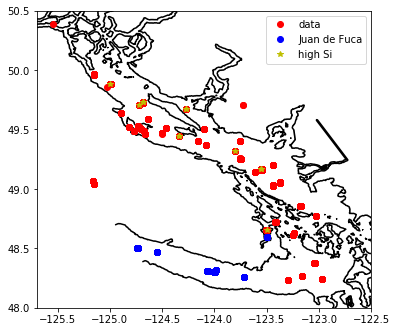

In [5]:
fig, ax = plt.subplots(figsize = (6,6))
viz_tools.set_aspect(ax, coords = 'map')
ax.plot(data['Lon'], data['Lat'], 'ro',label='data')
ax.plot(data.loc[(data.Lon < -123.5) & (data.Lat < 48.6),['Lon']], 
        data.loc[(data.Lon < -123.5) & (data.Lat < 48.6),['Lat']], 
        'bo', label = 'Juan de Fuca')

ax.plot(data.loc[data.Si>75,['Lon']],data.loc[data.Si>75,['Lat']],'*',color='y',label='high Si')
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_ylim(48, 50.5)
ax.legend()
ax.set_xlim(-125.7, -122.5);

# Nitrate

In [6]:
N_s, modmean_s, obsmean_s, bias_s, RMSE_s, WSS_s = et.stats(data.loc[data.Z<15,['N']],data.loc[data.Z<15,['mod_nitrate']])
N_i, modmean_i, obsmean_i, bias_i, RMSE_i, WSS_i = et.stats(data.loc[(data.Z>=15)&(data.Z<22),['N']],data.loc[(data.Z>=15)&(data.Z<22),['mod_nitrate']])
N_d, modmean_d, obsmean_d, bias_d, RMSE_d, WSS_d = et.stats(data.loc[data.Z>=22,['N']],data.loc[data.Z>=22,['mod_nitrate']])
N, modmean, obsmean, bias, RMSE, WSS = et.stats(data.loc[:,['N']],data.loc[:,['mod_nitrate']])
print('Nitrate')
print('z<15 m:')
print('  N: {}\n  bias: {}\n  RMSE: {}\n  WSS: {}'.format(N_s,bias_s,RMSE_s,WSS_s))
print('15 m<=z<22 m:')
print('  N: {}\n  bias: {}\n  RMSE: {}\n  WSS: {}'.format(N_i,bias_i,RMSE_i,WSS_i))
print('z>=22 m:')
print('  N: {}\n  bias: {}\n  RMSE: {}\n  WSS: {}'.format(N_d,bias_d,RMSE_d,WSS_d))
print('all:')
print('  N: {}\n  bias: {}\n  RMSE: {}\n  WSS: {}'.format(N,bias,RMSE,WSS))


Nitrate
z<15 m:
  N: 517
  bias: 6.575154043673548
  RMSE: 10.6824143237183
  WSS: 0.7259881232788695
15 m<=z<22 m:
  N: 140
  bias: 9.329637908935542
  RMSE: 11.211493527742366
  WSS: 0.5373992885146764
z>=22 m:
  N: 959
  bias: 9.772233330305976
  RMSE: 11.623031483563858
  WSS: 0.4288410283561973
all:
  N: 1616
  bias: 8.711061392302561
  RMSE: 11.294618868170515
  WSS: 0.7186515776378078


(0, 35)

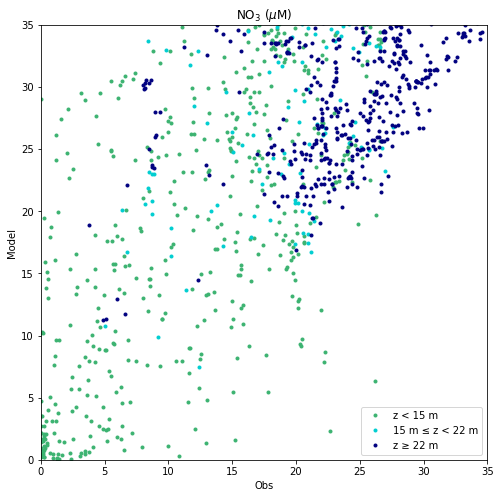

In [7]:
fig, ax = plt.subplots(figsize = (8,8))
ps=et.varvarPlot(ax,data,'N','mod_nitrate','Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
ax.legend(handles=ps)
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.set_title('NO$_3$ ($\mu$M)')
ax.set_xlim(0,35)
ax.set_ylim(0,35)

Nitrate, z<15
Feb-Mar:
  N: 42
  bias: 8.413872825985862
  RMSE: 8.845187585041606
  WSS: 0.6218878333182538
April:
  N: 188
  bias: 14.07609011548631
  RMSE: 15.04864703049606
  WSS: 0.5008602715400334
May-Jun:
  N: 187
  bias: 1.3216037995037535
  RMSE: 6.249907263669015
  WSS: 0.8422050284440669
Sep-Oct:
  N: 100
  bias: 1.5252652313232424
  RMSE: 7.636538591505394
  WSS: 0.7956781879597679


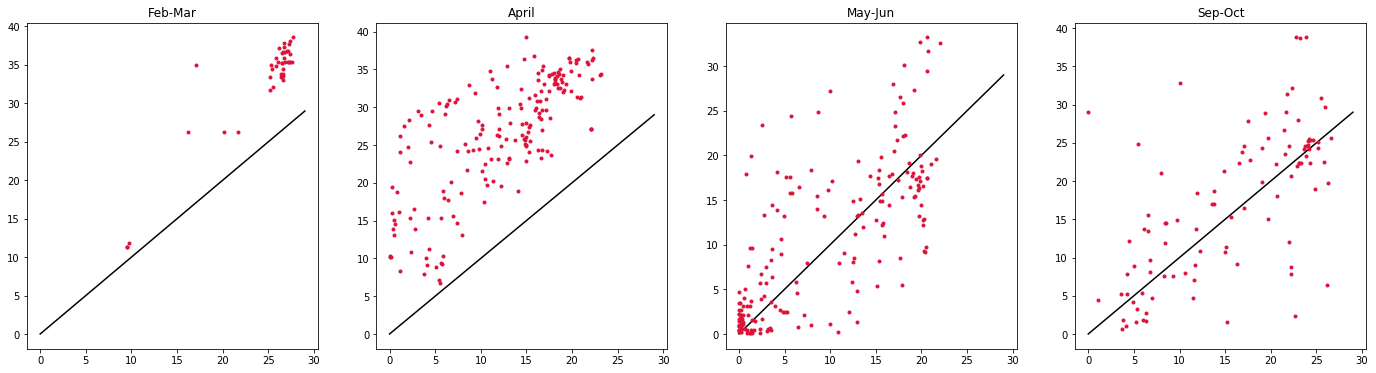

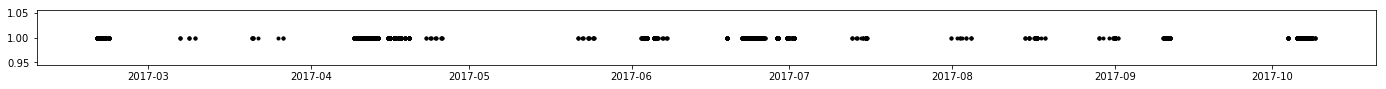

In [8]:
fig, ax = plt.subplots(1,4,figsize = (24,6))
for axi in ax:
    axi.plot(np.arange(0,30),np.arange(0,30),'k-')
ps=et.varvarPlot(ax[0],data.loc[(data.Z<15)&(data.dtUTC<=dt.datetime(start_date.year,4,1)),:],'N','mod_nitrate',cols=('crimson','darkturquoise','navy'))
ax[0].set_title('Feb-Mar')
ii1=(data.Z < 15)&(data.dtUTC<=dt.datetime(start_date.year,5,1))&(data.dtUTC>dt.datetime(start_date.year,4,1))
ps=et.varvarPlot(ax[1],data.loc[ii1,:],'N','mod_nitrate',cols=('crimson','darkturquoise','navy'))
ax[1].set_title('April')
ii2=(data.Z < 15)&(data.dtUTC<=dt.datetime(start_date.year,9,1))&(data.dtUTC>dt.datetime(start_date.year,5,1))
ps=et.varvarPlot(ax[2],data.loc[ii2,:],'N','mod_nitrate',cols=('crimson','darkturquoise','navy'))
ax[2].set_title('May-Jun')
ii3=(data.Z < 15)&(data.dtUTC<=dt.datetime(start_date.year,12,1))&(data.dtUTC>dt.datetime(start_date.year,9,1))
ps=et.varvarPlot(ax[3],data.loc[ii3,:],'N','mod_nitrate',cols=('crimson','darkturquoise','navy'))
ax[3].set_title('Sep-Oct')

print('Nitrate, z<15')
print('Feb-Mar:')
et.printstats(data.loc[(data.Z<15)&(data.dtUTC<=dt.datetime(start_date.year,4,1)),:],'N','mod_nitrate')
print('April:')
et.printstats(data.loc[ii1,:],'N','mod_nitrate')
print('May-Jun:')
et.printstats(data.loc[ii2,:],'N','mod_nitrate')
print('Sep-Oct:')
et.printstats(data.loc[ii3,:],'N','mod_nitrate')
fig,ax=plt.subplots(1,1,figsize=(24,1))
plt.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')

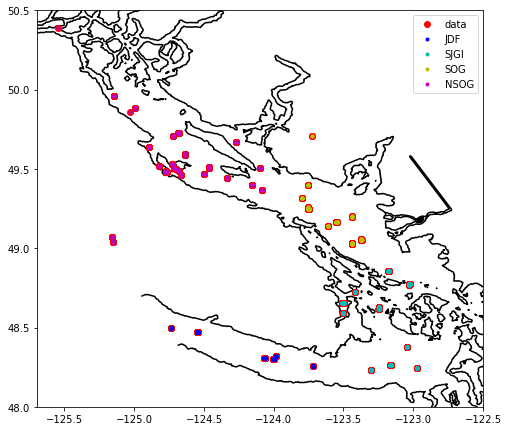

In [9]:
fig, ax = plt.subplots(figsize = (8,8))
viz_tools.set_aspect(ax, coords = 'map')
ax.plot(data['Lon'], data['Lat'], 'ro',label='data')
dJDF=data.loc[(data.Lon<-123.6)&(data.Lat<48.6)]
ax.plot(dJDF['Lon'],dJDF['Lat'],'b.',label='JDF')
dSJGI=data.loc[(data.Lon>=-123.6)&(data.Lat<48.9)]
ax.plot(dSJGI['Lon'],dSJGI['Lat'],'c.',label='SJGI')
dSOG=data.loc[(data.Lat>=48.9)&(data.Lon>-124.0)]
ax.plot(dSOG['Lon'],dSOG['Lat'],'y.',label='SOG')
dNSOG=data.loc[(data.Lat>=48.9)&(data.Lon<=-124.0)]
ax.plot(dNSOG['Lon'],dNSOG['Lat'],'m.',label='NSOG')
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_ylim(48, 50.5)
ax.legend()
ax.set_xlim(-125.7, -122.5);

(0, 50)

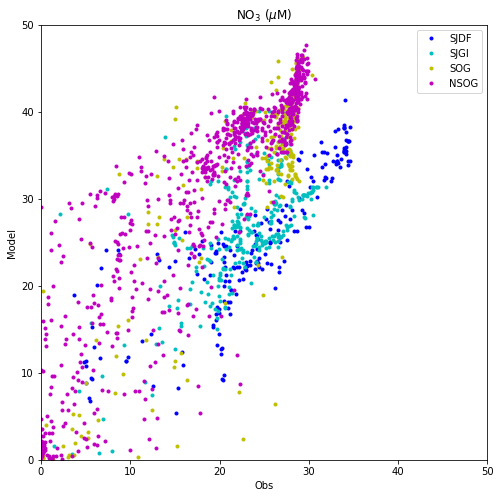

In [10]:
fig, ax = plt.subplots(figsize = (8,8))
ps1=et.varvarPlot(ax,dJDF,'N','mod_nitrate',cols=('b','darkturquoise','navy'),lname='SJDF')
ps2=et.varvarPlot(ax,dSJGI,'N','mod_nitrate',cols=('c','darkturquoise','navy'),lname='SJGI')
ps3=et.varvarPlot(ax,dSOG,'N','mod_nitrate',cols=('y','darkturquoise','navy'),lname='SOG')
ps4=et.varvarPlot(ax,dNSOG,'N','mod_nitrate',cols=('m','darkturquoise','navy'),lname='NSOG')
ax.legend(handles=[ps1[0][0],ps2[0][0],ps3[0][0],ps4[0][0]])
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.set_title('NO$_3$ ($\mu$M)')
ax.set_xlim(0,50)
ax.set_ylim(0,50)

(-40, 20)

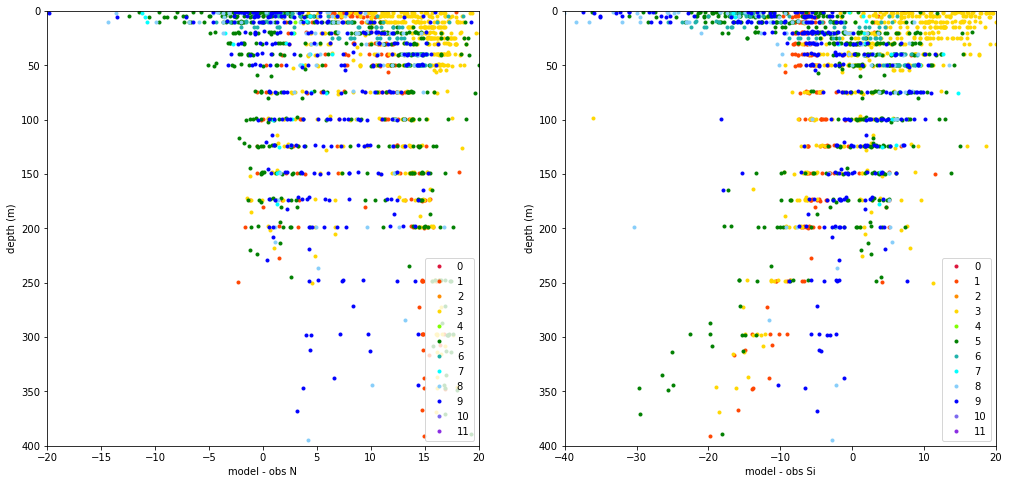

In [11]:
fig, ax = plt.subplots(1,2,figsize = (17,8))
cols=('crimson','orangered','darkorange','gold','chartreuse','green','lightseagreen','cyan',
      'lightskyblue','blue','mediumslateblue','blueviolet','darkmagenta','fuchsia')
ii0=start_date
for ii in range(0,int((end_date-start_date).days/30)):
    iii=(data.dtUTC>=(start_date+dt.timedelta(days=ii*30)))&(data.dtUTC<(start_date+dt.timedelta(days=(ii+1)*30)))
    ax[0].plot(data.loc[iii,['mod_nitrate']].values-data.loc[iii,['N']].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
    ax[1].plot(data.loc[iii,['mod_silicon']].values-data.loc[iii,['Si']].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
for axi in (ax[0],ax[1]):
    axi.legend(loc=4)
    axi.set_ylim(400,0)
    axi.set_ylabel('depth (m)')
ax[0].set_xlabel('model - obs N')
ax[0].set_xlim(-20,20)
ax[1].set_xlabel('model - obs Si')
ax[1].set_xlim(-40,20)

# Silicate

In [12]:
print('Silicate')
print('z<15 m:')
et.printstats(data.loc[data.Z<15,:],'Si','mod_silicon')
print('15 m<=z<22 m:')
et.printstats(data.loc[(data.Z>=15)&(data.Z<22),:],'Si','mod_silicon')
print('z>=22 m:')
et.printstats(data.loc[data.Z>=22,:],'Si','mod_silicon')
print('all:')
et.printstats(data,'Si','mod_silicon')


Silicate
z<15 m:
  N: 517
  bias: -3.178074274856307
  RMSE: 16.456426183636584
  WSS: 0.6401765116247735
15 m<=z<22 m:
  N: 140
  bias: 0.14141850062778616
  RMSE: 9.47203096801912
  WSS: 0.7501790079907644
z>=22 m:
  N: 958
  bias: 0.10288564662097599
  RMSE: 7.776273014633733
  WSS: 0.7508323576017741
all:
  N: 1615
  bias: -0.9440877624133748
  RMSE: 11.41673842863339
  WSS: 0.8088495389365362


(0, 85)

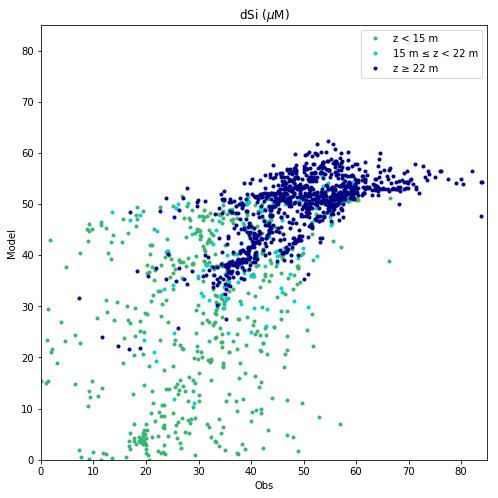

In [13]:
fig, ax = plt.subplots(figsize = (8,8))
ps=et.varvarPlot(ax,data,'Si','mod_silicon','Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
ax.legend(handles=ps)
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.set_title('dSi ($\mu$M)')
ax.set_xlim(0,85)
ax.set_ylim(0,85)

Silicate, z<15
Feb-Mar:
  N: 42
  bias: -6.220955941336491
  RMSE: 7.136490218931224
  WSS: 0.8637262059890933
April:
  N: 188
  bias: 13.365900895139006
  RMSE: 16.370425874975886
  WSS: 0.6052512112528492
May-Jun:
  N: 187
  bias: -11.48295394448673
  RMSE: 14.463126213318029
  WSS: 0.6548408074922333
Sep-Oct:
  N: 100
  bias: -17.472610977172856
  RMSE: 21.99374087877037
  WSS: 0.4264253625303418


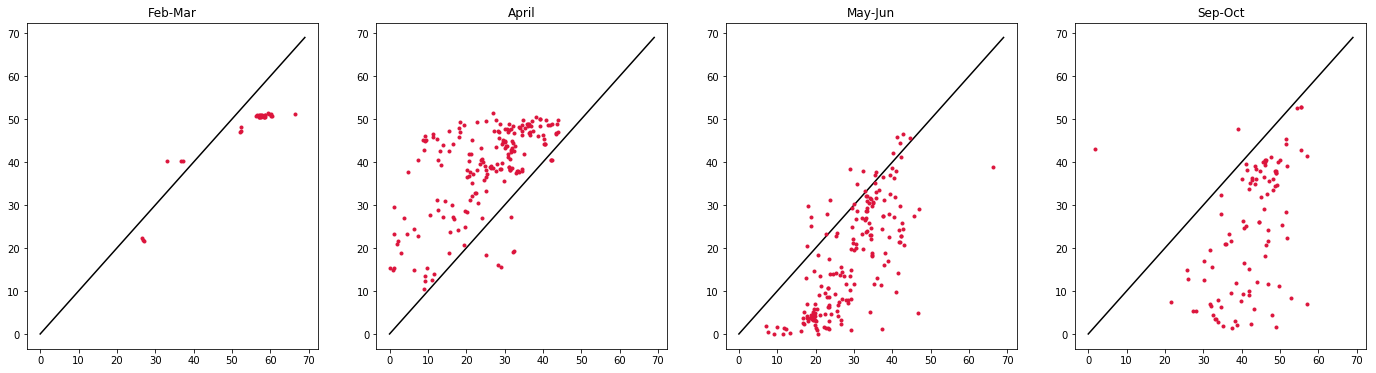

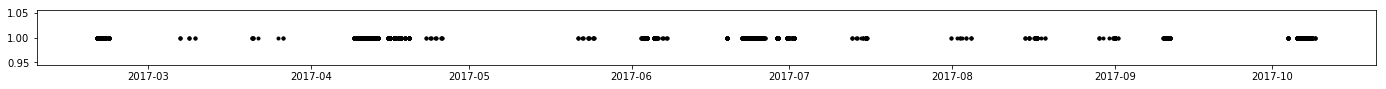

In [14]:
obsvar='Si'; modvar='mod_silicon'
fig, ax = plt.subplots(1,4,figsize = (24,6))
for axi in ax:
    axi.plot(np.arange(0,70),np.arange(0,70),'k-')
ps=et.varvarPlot(ax[0],data.loc[(data.Z<15)&(data.dtUTC<=dt.datetime(start_date.year,4,1)),:],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
ax[0].set_title('Feb-Mar')
ii1=(data.Z < 15)&(data.dtUTC<=dt.datetime(start_date.year,5,1))&(data.dtUTC>dt.datetime(start_date.year,4,1))
ps=et.varvarPlot(ax[1],data.loc[ii1,:],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
ax[1].set_title('April')
ii2=(data.Z < 15)&(data.dtUTC<=dt.datetime(start_date.year,9,1))&(data.dtUTC>dt.datetime(start_date.year,5,1))
ps=et.varvarPlot(ax[2],data.loc[ii2,:],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
ax[2].set_title('May-Jun')
ii3=(data.Z < 15)&(data.dtUTC<=dt.datetime(start_date.year,12,1))&(data.dtUTC>dt.datetime(start_date.year,9,1))
ps=et.varvarPlot(ax[3],data.loc[ii3,:],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
ax[3].set_title('Sep-Oct')

print('Silicate, z<15')
print('Feb-Mar:')
et.printstats(data.loc[(data.Z<15)&(data.dtUTC<=dt.datetime(start_date.year,4,1)),:],obsvar,modvar)
print('April:')
et.printstats(data.loc[ii1,:],obsvar,modvar)
print('May-Jun:')
et.printstats(data.loc[ii2,:],obsvar,modvar)
print('Sep-Oct:')
et.printstats(data.loc[ii3,:],obsvar,modvar)
fig,ax=plt.subplots(1,1,figsize=(24,1))
plt.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')

(0, 85)

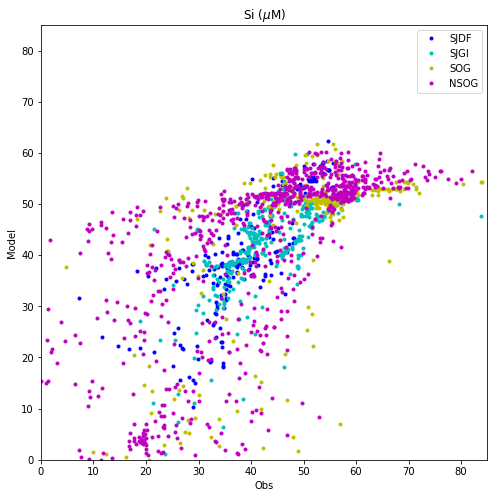

In [15]:
fig, ax = plt.subplots(figsize = (8,8))
ps1=et.varvarPlot(ax,dJDF,obsvar,modvar,cols=('b','darkturquoise','navy'),lname='SJDF')
ps2=et.varvarPlot(ax,dSJGI,obsvar,modvar,cols=('c','darkturquoise','navy'),lname='SJGI')
ps3=et.varvarPlot(ax,dSOG,obsvar,modvar,cols=('y','darkturquoise','navy'),lname='SOG')
ps4=et.varvarPlot(ax,dNSOG,obsvar,modvar,cols=('m','darkturquoise','navy'),lname='NSOG')
ax.legend(handles=[ps1[0][0],ps2[0][0],ps3[0][0],ps4[0][0]])
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.set_title('Si ($\mu$M)')
ax.set_xlim(0,85)
ax.set_ylim(0,85)

# Ratios

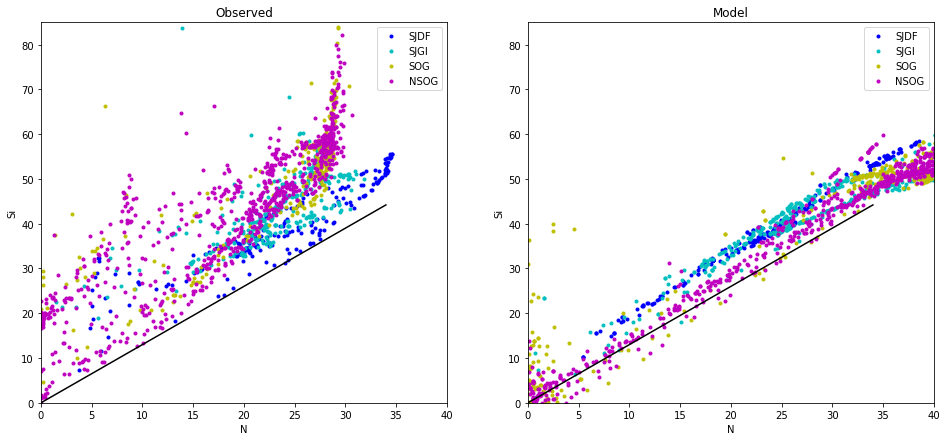

In [16]:
fig,ax=plt.subplots(1,2,figsize=(16,7))
p1=ax[0].plot(dJDF['N'],dJDF['Si'],'b.',label='SJDF')
p2=ax[0].plot(dSJGI['N'],dSJGI['Si'],'c.',label='SJGI')
p3=ax[0].plot(dSOG['N'],dSOG['Si'],'y.',label='SOG')
p4=ax[0].plot(dNSOG['N'],dNSOG['Si'],'m.',label='NSOG')
ax[0].set_title('Observed')
ax[0].set_xlabel('N')
ax[0].set_ylabel('Si')
ax[0].set_xlim(0,40)
ax[0].set_ylim(0,85)
ax[0].legend()

p5=ax[1].plot(dJDF['mod_nitrate'],dJDF['mod_silicon'],'b.',label='SJDF')
p6=ax[1].plot(dSJGI['mod_nitrate'],dSJGI['mod_silicon'],'c.',label='SJGI')
p7=ax[1].plot(dSOG['mod_nitrate'],dSOG['mod_silicon'],'y.',label='SOG')
p8=ax[1].plot(dNSOG['mod_nitrate'],dNSOG['mod_silicon'],'m.',label='NSOG')
ax[1].set_title('Model')
ax[1].set_xlabel('N')
ax[1].set_ylabel('Si')
ax[1].set_xlim(0,40)
ax[1].set_ylim(0,85)
ax[1].legend()
ax[0].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')
ax[1].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')

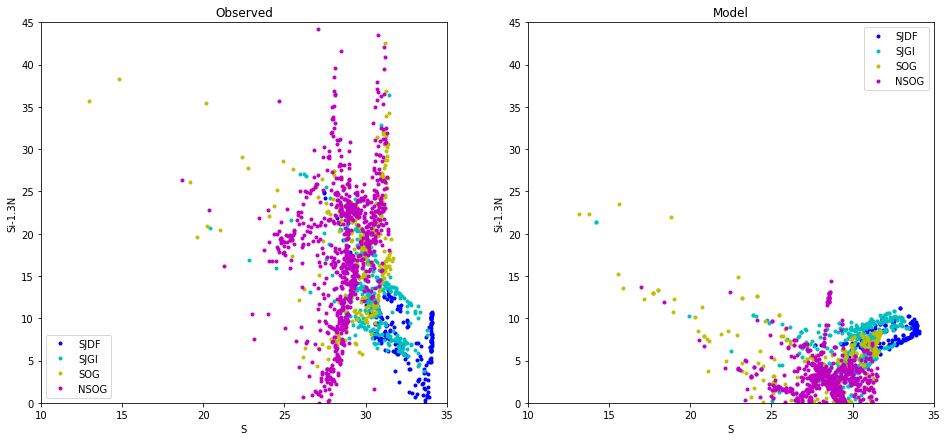

In [17]:
fig,ax=plt.subplots(1,2,figsize=(16,7))
p1=ax[0].plot(dJDF['AbsSal'], dJDF['Si']-1.3*dJDF['N'],'b.',label='SJDF')
p2=ax[0].plot(dSJGI['AbsSal'],dSJGI['Si']-1.3*dSJGI['N'],'c.',label='SJGI')
p3=ax[0].plot(dSOG['AbsSal'],dSOG['Si']-1.3*dSOG['N'],'y.',label='SOG')
p4=ax[0].plot(dNSOG['AbsSal'],dNSOG['Si']-1.3*dNSOG['N'],'m.',label='NSOG')
ax[0].set_title('Observed')
ax[0].set_xlabel('S')
ax[0].set_ylabel('Si-1.3N')
ax[0].set_xlim(10,35)
ax[0].set_ylim(0,45)
ax[0].legend()

p5=ax[1].plot(dJDF['mod_vosaline'],dJDF['mod_silicon']-1.3*dJDF['mod_nitrate'],'b.',label='SJDF')
p6=ax[1].plot(dSJGI['mod_vosaline'],dSJGI['mod_silicon']-1.3*dSJGI['mod_nitrate'],'c.',label='SJGI')
p7=ax[1].plot(dSOG['mod_vosaline'],dSOG['mod_silicon']-1.3*dSOG['mod_nitrate'],'y.',label='SOG')
p8=ax[1].plot(dNSOG['mod_vosaline'],dNSOG['mod_silicon']-1.3*dNSOG['mod_nitrate'],'m.',label='NSOG')
ax[1].set_title('Model')
ax[1].set_xlabel('S')
ax[1].set_ylabel('Si-1.3N')
ax[1].set_xlim(10,35)
ax[1].set_ylim(0,45)
ax[1].legend()

In [18]:
data.loc[data.Si>65,['Month','Lat','Lon','Z','Si']]

,Month,Lat,Lon,Z,Si
80,2.0,49.027667,-123.437833,297.5,66.85
81,2.0,49.027667,-123.437833,311.8,67.82
97,2.0,49.163167,-123.551000,347.1,66.29
98,2.0,49.163167,-123.551000,367.2,68.34
109,2.0,49.250833,-123.749000,390.9,72.03
140,2.0,49.402000,-124.155167,272.6,65.08
153,2.0,49.466500,-124.499500,316.1,69.51
169,2.0,49.730000,-124.685000,347.9,68.70
184,2.0,49.885333,-124.995333,307.2,66.13
185,2.0,49.483667,-124.766667,0.6,66.38


# Chlorophyll

In [19]:
data['l10_obsChl']=np.log10(data['Chlorophyll_Extracted']+0.01)
data['l10_modChl']=np.log10(2*(data['mod_diatoms']+data['mod_ciliates']+data['mod_flagellates'])+0.01)
data['mod_Chl']=2*(data['mod_diatoms']+data['mod_ciliates']+data['mod_flagellates'])

In [20]:
print('log10[Chl+0.01]')
print('z<15 m:')
et.printstats(data.loc[data.Z<15,:],'l10_obsChl','l10_modChl')
print('z>=15 m:')
et.printstats(data.loc[data.Z>=15,:],'l10_obsChl','l10_modChl')
print('all:')
et.printstats(data,'l10_obsChl','l10_modChl')
print('\n')
print('Chl')
print('z<15 m:')
et.printstats(data.loc[data.Z<15,:],'Chlorophyll_Extracted','mod_Chl')
print('z>=15 m:')
et.printstats(data.loc[data.Z>=15,:],'Chlorophyll_Extracted','mod_Chl')
print('all:')
et.printstats(data,'Chlorophyll_Extracted','mod_Chl')


log10[Chl+0.01]
z<15 m:
  N: 317
  bias: 0.20779246095154263
  RMSE: 0.5620392698907483
  WSS: 0.521300427749373
z>=15 m:
  N: 122
  bias: 0.2913157908009911
  RMSE: 0.547922329015224
  WSS: 0.5297341363921382
all:
  N: 439
  bias: 0.23100392722683877
  RMSE: 0.5581519372883971
  WSS: 0.5963155209138211


Chl
z<15 m:
  N: 317
  bias: 0.9428577859318974
  RMSE: 5.8182730405256935
  WSS: 0.5222697029334373
z>=15 m:
  N: 122
  bias: 0.5596486440252086
  RMSE: 1.8135381186396786
  WSS: 0.4880786896221889
all:
  N: 439
  bias: 0.8363627228704287
  RMSE: 5.035732857098481
  WSS: 0.5707228205474831


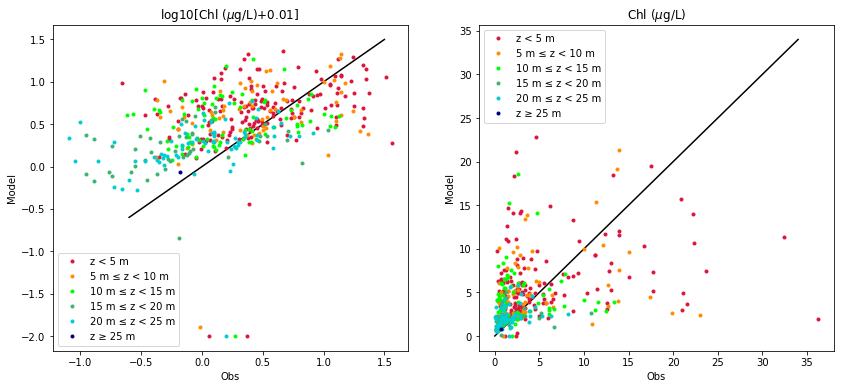

In [21]:
fig, ax = plt.subplots(1,2,figsize = (14,6))
ax[0].plot(np.arange(-.6,1.6,.1),np.arange(-.6,1.6,.1),'k-')
ps=et.varvarPlot(ax[0],data,'l10_obsChl','l10_modChl','Z',(5,10,15,20,25),'z','m',('crimson','darkorange','lime','mediumseagreen','darkturquoise','navy'))
ax[0].legend(handles=ps)
ax[0].set_xlabel('Obs')
ax[0].set_ylabel('Model')
ax[0].set_title('log10[Chl ($\mu$g/L)+0.01]')
ax[1].plot(np.arange(0,35),np.arange(0,35),'k-')
ps=et.varvarPlot(ax[1],data,'Chlorophyll_Extracted','mod_Chl','Z',(5,10,15,20,25),'z','m',('crimson','darkorange','lime','mediumseagreen','darkturquoise','navy'))
ax[1].legend(handles=ps)
ax[1].set_xlabel('Obs')
ax[1].set_ylabel('Model')
ax[1].set_title('Chl ($\mu$g/L)')